In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from download import query_phe as query, download_phe as download, find_latest, is_msoa_data_ready
from msoa_composite import check_path
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from vaccination import vaccination_dashboard, vaccination_changes
import requests

In [10]:
release=None

In [11]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-02-02,2021-02-01,United Kingdom,K02000001,NaN,NaN,NaN,643204.0
1,2021-02-02,2021-01-31,United Kingdom,K02000001,12844.0,NaN,504.0,574012.0
2,2021-02-02,2021-01-30,United Kingdom,K02000001,15787.0,NaN,571.0,439006.0
3,2021-02-02,2021-01-29,United Kingdom,K02000001,21050.0,2642.0,741.0,662675.0
4,2021-02-02,2021-01-28,United Kingdom,K02000001,23824.0,3018.0,920.0,753031.0
...,...,...,...,...,...,...,...,...
364,2021-02-02,2020-02-03,United Kingdom,K02000001,0.0,NaN,NaN,NaN
365,2021-02-02,2020-02-02,United Kingdom,K02000001,0.0,NaN,NaN,NaN
366,2021-02-02,2020-02-01,United Kingdom,K02000001,1.0,NaN,NaN,NaN
367,2021-02-02,2020-01-31,United Kingdom,K02000001,1.0,NaN,NaN,NaN


In [12]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-02-02.csv')

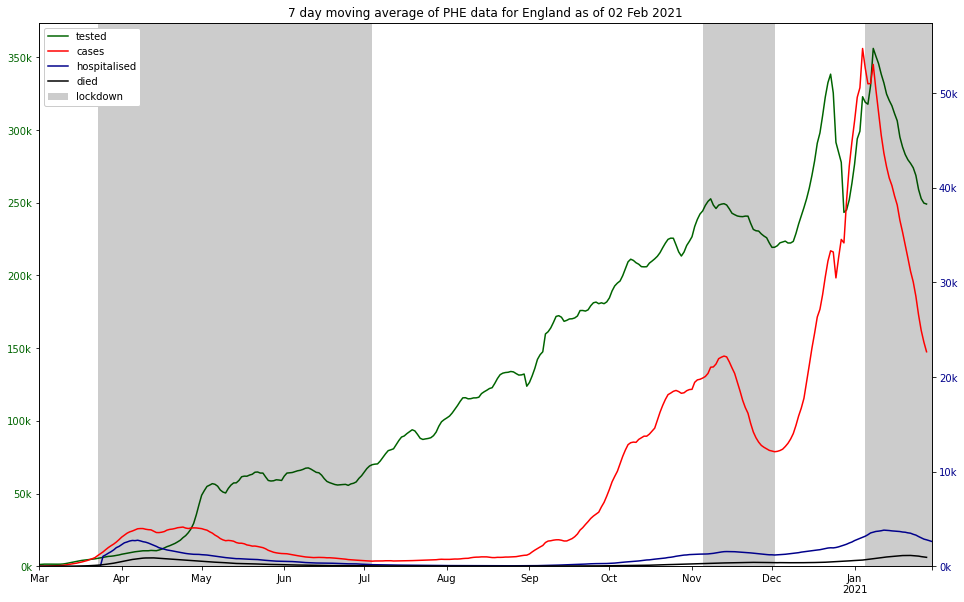

In [13]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [14]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-02-02.csv')

In [15]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-02-02.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,Northern Ireland,N92000002,24882.0,233429.0,208547.0,1893667,1.313959,11.012866,87.673176
1,Scotland,S92000003,8345.0,610778.0,602433.0,5463300,0.152747,11.026907,88.820347
2,Wales,W92000004,1066.0,439640.0,438574.0,3152879,0.033810,13.910271,86.055919
3,England,E92000001,462503.0,8362868.0,7900365.0,56286961,0.821688,14.035871,85.142442


'partial: 9,646,715'

'full: 496,796'

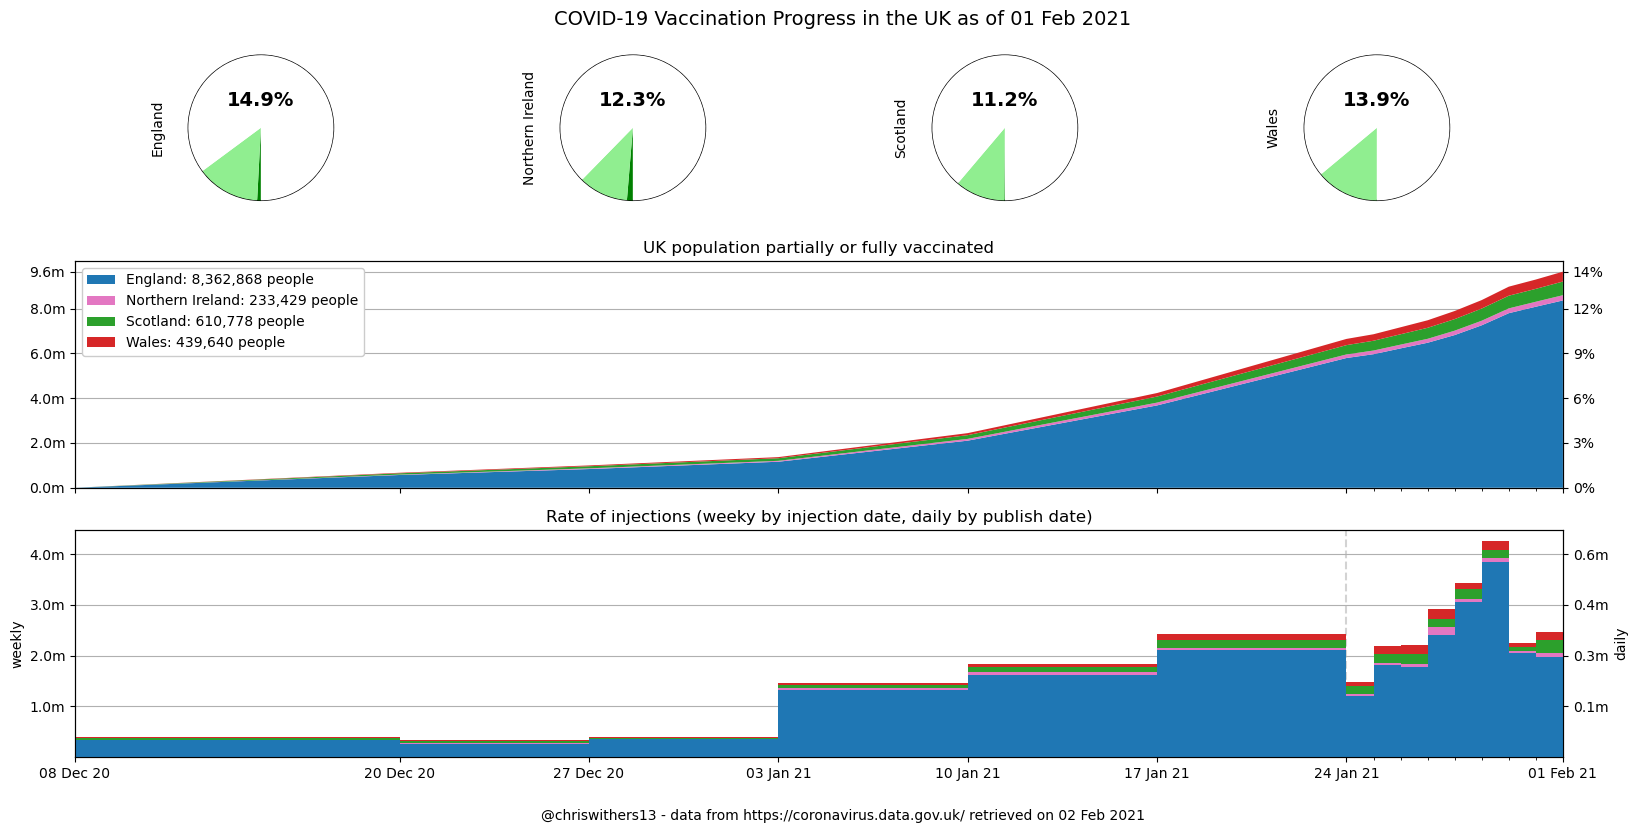

In [7]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}", f"full: {results['full'].sum():,.0f}")

In [17]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,01 Feb 21,"+280,513","+1,596","+1,596","+8,362,868","+462,503","+462,503"
Northern Ireland,01 Feb 21,"+11,620",+270,+270,"+233,429","+24,882","+24,882"
Scotland,01 Feb 21,"+34,881",+496,+496,"+610,778","+8,345","+8,345"
Wales,01 Feb 21,"+23,334",+225,+225,"+439,640","+1,066","+1,066"


In [18]:
download(nation, nation, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-02-02.csv')

In [19]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-02-02.csv')

In [20]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-02-02.csv')

In [4]:
if is_msoa_data_ready():
    path = download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change, 'release', release=release)
    display(path)
    check_path(path)

today: 2021-02-02, release: 2021-02-02 16:00:49.765892+00:00, msoa: 2021-02-01 16:18:51+00:00
